### 使用opensmile提取音频特征

In [85]:
import opensmile
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 1、构造特征提取函数

In [86]:
## 提取特征函数
## file_list:音频文件路径的列表  list类型
## 返回值numpy.ndarray  形状:(len(file_list),88)
def extract_audio_feature(file_list,save_path):
    # 如果已存在保存的特征文件，则直接加载
    if os.path.exists(save_path):
        print(f"已找到保存的特征文件 '{save_path}'，正在加载...")
        feature = np.load(save_path)
        print("特征加载完毕！")
        return feature    
    print("请耐心等待特征提取完！")
    smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals)#指定了特征集（eGeMAPSv02）和特征级别（Functionals）
    feature = []
    for n,file in enumerate(file_list):#enumerate函数用于遍历，返回一个迭代器（索引和值）
        y = smile.process_file(file)#调用process_file函数处理音频文件
        y = y.to_numpy().reshape(-1)#-1 表示自动计算这一维的大小
        feature.append(y)
        if (n+1)%100 == 0:
            print(f"当前进度{n+1}/{len(file_list)}")
    print("此次特征提取已结束")
    print("-------------------------------")
    feature = np.stack(feature,axis = 0)
    # 将特征保存到指定的文件中
    np.save(save_path, feature)
    print(f"特征已保存到文件 '{save_path}'")
    
    return feature

In [87]:
def normalize_features(features, scaler=None, method='minmax'):
    """
    对已提取的特征进行归一化或标准化处理，并应用训练集的归一化参数。
    
    参数:
    features: numpy.ndarray, 待归一化的特征数据，形状为 (n_samples, n_features)
    scaler: 已拟合的归一化器（标准化或归一化器），如果没有提供，则会根据训练集拟合一个新的
    method: str, 归一化方法，'standard'为标准化（Z-score），'minmax'为最小-最大归一化，默认 'standard'
    
    返回:
    numpy.ndarray: 归一化后的特征数据
    """
    if method == 'standard':  # 使用标准化 (Z-score)
        if scaler is None:  # 如果没有提供 scaler，就拟合一个新的
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
        else:  # 如果提供了 scaler，就应用已经拟合好的归一化参数
            features = scaler.transform(features)
        print("标准化（Z-score）完成")
    
    elif method == 'minmax':  # 使用最小-最大归一化
        if scaler is None:
            scaler = MinMaxScaler()
            features = scaler.fit_transform(features)
        else:
            features = scaler.transform(features)
        print("最小-最大归一化完成")
    
    else:
        raise ValueError("未知的归一化方法，请选择 'standard' 或 'minmax'。")
    
    return features, scaler

In [88]:
## 特征提取示例
#file = "./train/Ses01F_impro01_F000.wav"
#audio_feature = extract_audio_feature([file])
#print(type(audio_feature),audio_feature.shape)

## 2、csv文件读入示例

In [89]:
## 读入csv文件示例
## 由于我们的csv文件使用"#"分隔，需要定义sep参数为"#",否则会读取失败！！！
train_csv = pd.read_csv("./CSVfile/train.csv",sep="#")

In [90]:
## 快速查看前5条数据
train_csv.head(5)

,num,id,path,text,label
0,1,Ses01F_impro01_F000,train/Ses01F_impro01_F000.wav,Excuse me.,2
1,2,Ses01F_impro01_F001,train/Ses01F_impro01_F001.wav,Yeah.,2
2,3,Ses01F_impro01_F002,train/Ses01F_impro01_F002.wav,Is there a problem?,2
3,4,Ses01F_impro01_F005,train/Ses01F_impro01_F005.wav,Well what's the problem? Let me change it.,2
4,5,Ses01F_impro01_F012,train/Ses01F_impro01_F012.wav,That's out of control.,0


In [91]:
## 统计该csv下lable列不同值的数量
train_csv.value_counts(subset="label")

label
2    1066
1     891
3     696
0     606
Name: count, dtype: int64

Text(0.5, 1.0, 'Train dataset sample distribution')

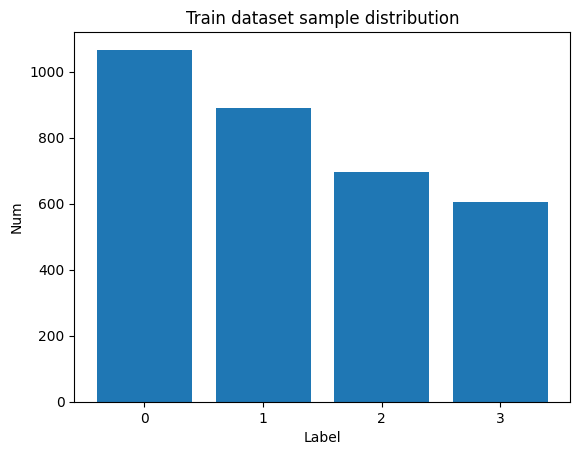

In [92]:
## 画图显示类别数
plt.bar([0,1,2,3],list(train_csv.value_counts(subset="label")),tick_label = ["0","1","2","3"])
plt.xlabel("Label")
plt.ylabel("Num")
plt.title("Train dataset sample distribution")

## 3、性能指标函数

In [93]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [94]:
def calculate_score_classification(preds, labels, average_f1='macro'):  # weighted, macro
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average=average_f1, zero_division=0)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    ua = recall_score(labels, preds, average='macro', zero_division=0)
    confuse_matrix = confusion_matrix(labels, preds)
    return accuracy, ua, f1, precision, confuse_matrix

### 4、构造机器学习模型

In [95]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV  # 导入贝叶斯优化类
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC

class MyRF:
    def __init__(self,C=0.01, kernel='poly',gamma='scale'):
        self.model = SVC(kernel=kernel, C=C, gamma=gamma,class_weight=None)
        self.param_space = {
            # 'C': Real(0.01, 4, prior='log-uniform'),  # C的范围
            # 'gamma': Categorical(['scale']) ,
            'degree': Integer(4, 8),  # 仅对poly核有效，表示多项式核的度数
            'coef0': Real(-1.0, 1.0),  # poly和sigmoid核的偏置项
            # 处理类别不平衡
            'tol': Real(5e-5, 1e-1, prior='log-uniform'),  # 容忍度范围，采用对数均匀分布
        }

    def train(self, features, labels):
        print("开始贝叶斯优化...")

        # 使用贝叶斯优化来寻找最佳参数
        bayes_search = BayesSearchCV(self.model, self.param_space, n_iter=100, cv=5, scoring='f1_macro', verbose=1)
        bayes_search.fit(features, labels)
        
        print("贝叶斯优化完成，最佳参数：", bayes_search.best_params_)
        self.model = bayes_search.best_estimator_
        print("SVM模型训练完成！")

    def evaluate(self, features, labels):
        # 在验证集上评估模型
        print("开始评估模型...")
        preds = self.model.predict(features)
        accuracy, recall, f1, precision, conf_matrix = calculate_score_classification(preds, labels)
        return accuracy, recall, f1, precision, conf_matrix

## 5、读取csv文件，分离音频文件路径、标签

In [96]:
## 读取train.csv、dev.csv
train_csv = pd.read_csv("./CSVfile/train.csv", sep = "#")
dev_csv = pd.read_csv("./CSVfile/dev.csv", sep = "#")
## 分离文件路径和标签
## 可先截取少量样本验证代码正确性，再使用所有样本
# train_path = list(train_csv.path)[:100]
# train_label = list(train_csv.label)[:100]
# dev_path = list(dev_csv.path)[:50]
# dev_label = list(dev_csv.label)[:50]

train_path = list(train_csv.path)
train_label = list(train_csv.label)
dev_path = list(dev_csv.path)
dev_label = list(dev_csv.label)

## 6、结果写入函数

In [97]:
## test_preds 长度为1241的list，对应测试集中1241个样本的标签
##运行后会在当前目录生成result.csv文件，提交result.csv文件即可
##如果没有生成，请检查test_preds的长度是否为1241！
def write_result(test_preds):
    if len(test_preds) != 1241:
        print("错误！请检查test_preds长度是否为1241！！！")
        return -1
    test_csv = pd.read_csv("./CSVfile/test.csv",sep="#")
    test_csv["label"] = test_preds
    test_csv.to_csv("./result.csv",sep = "#")
    print("测试集预测结果已成功写入到文件中！")

## 7、特征预处理函数、主函数

In [98]:
## 特征处理函数，可以对提取的特征进行处理，以获得更好的特征表示
def feature_process(feature):
    return feature

## 主函数
if __name__ == "__main__":
    ## 实例化模型
    rf = MyRF()
    ## 提取训练样本特征
    ## 文件数量很多时需要的时间较长，请耐心等待
    train_save_path="./feature/train_feature.npy"
    train_feature = extract_audio_feature(train_path,train_save_path) ## np.array (n,88)
    train_feature_normalized, scaler = normalize_features(train_feature, method='minmax')
    train_feature = feature_process(train_feature_normalized)

    ##训练模型
    rf.train(train_feature_normalized,train_label)
    ##评估在训练集上的拟合效果
    acc,ua,f1,pre,confuse_matrix = rf.evaluate(train_feature_normalized,np.array(train_label))
    print(f"train:\nAcc:{acc} \nUa:{ua} \nMacro_F1:{f1} \nPre:{pre}\nConfuse_matrix:\n{confuse_matrix}")
    
    ##计算在dev上的性能
    dev_save_path="./feature/dev_feature.npy"
    dev_feature = extract_audio_feature(dev_path,dev_save_path)
    dev_feature_normalized, _ = normalize_features(dev_feature, scaler=scaler, method='minmax')
    dev_feature = feature_process(dev_feature_normalized)
    acc,ua,f1,pre,confuse_matrix = rf.evaluate(dev_feature_normalized,np.array(dev_label))
    print(f"dev:\nAcc:{acc} \nUa:{ua} \nMacro_F1:{f1} \nPre:{pre}\nConfuse_matrix:\n{confuse_matrix}")
    
    #rf.show_and_save_models("model_info.txt")
    ##读入test.csv
    test_csv = pd.read_csv("./CSVfile/test.csv",sep = "#")
    test_path = list(test_csv.path)
    test_save_path="./feature/test_feature.npy"
    test_feature = extract_audio_feature(test_path,test_save_path)
    test_feature_normalized, _ = normalize_features(test_feature, scaler=scaler, method='minmax')
    test_label = rf.model.predict(test_feature_normalized)
    test_preds = test_label
    print(len(test_feature))
    
    ## 通过模型获得测试集对应的标签列表test_preds，并写入到result.csv文件中
    write_result(test_preds)

已找到保存的特征文件 './feature/train_feature.npy'，正在加载...
特征加载完毕！
最小-最大归一化完成
开始贝叶斯优化...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi